# Predicting Flight Delays

By: Grant Gittes, Sara Amato, Max Song

Source: https://www.kaggle.com/usdot/flight-delays

### Importing Data from CSV File

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
#preferences for reading tables, not that relevant in a smaller dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#Reason for Cancellation of flight: A - Airline/Carrier; B - Weather; C - National Air System; D - Security
flights = pd.read_csv("flights.csv")
airlines = pd.read_csv("airlines.csv")
airports = pd.read_csv("airports.csv")

C:\Users\Grant\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
flights = flights[1001000:1001100]

In [4]:
flights = flights.where(pd.notnull(flights), None)
airlines = airlines.where(pd.notnull(airlines), None)
airports = airports.where(pd.notnull(airports), None)

### Connecting to MySQL

In [5]:
import pymysql.cursors
con = pymysql.connect(host='134.209.169.96',
                             user='gbg2',
                             password='InfSci2710_3693437',
                             db='gbg2',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
# con = pymysql.connect(host='localhost',
#                              user='root',
#                              password='password',
#                              db='gbg3',
#                              charset='utf8mb4',
#                              cursorclass=pymysql.cursors.DictCursor)

In [6]:
with con.cursor() as cur:
    cur.execute('SHOW TABLES;')
    rows = cur.fetchall()
    for i in rows:
        print(i)

{'Tables_in_gbg2': 'actual_time'}
{'Tables_in_gbg2': 'airline_route'}
{'Tables_in_gbg2': 'airlines'}
{'Tables_in_gbg2': 'airport'}
{'Tables_in_gbg2': 'airport_location'}
{'Tables_in_gbg2': 'arrived'}
{'Tables_in_gbg2': 'cancellation'}
{'Tables_in_gbg2': 'cancelled'}
{'Tables_in_gbg2': 'delay'}
{'Tables_in_gbg2': 'delayed_description'}
{'Tables_in_gbg2': 'flight_master'}
{'Tables_in_gbg2': 'route'}
{'Tables_in_gbg2': 'sched_date'}
{'Tables_in_gbg2': 'scheduled_time'}


In [7]:
#count from flight master
with con.cursor() as cur:
    cur.execute('SELECT COUNT(*) FROM flight_master')
    rows = list(cur.fetchall()[0].values())[0]
print(rows)

1002000


### Functions for Adding Data to Database

In [8]:
#adds an airline
def add_to_airlines(con, id, name):
    with con.cursor() as cur:
        cur.execute('SELECT * FROM airlines WHERE airline_id=%s',(id))   
        rows = cur.fetchall()
        if(len(rows)==0):
            qry = 'INSERT INTO airlines (airline_id, name)'
            qry = qry + 'VALUES(%s, %s)'
            cur.execute(qry, (id, name))
            con.commit()
            print("added")
        else:
            print("in_db")

In [9]:
#adds airport
def add_to_airport(con, id, name):
    with con.cursor() as cur:
        cur.execute('SELECT * FROM airport WHERE airport_id=%s',(id))   
        rows = cur.fetchall()
        if(len(rows)==0):
            qry = 'INSERT INTO airport (airport_id, name)'
            qry = qry + 'VALUES(%s, %s)'
            cur.execute(qry, (id, name))
            con.commit()
            print("added")
        else:
            print("in_db")

In [10]:
#adds airport location
def add_to_airport_location(con, id, city, state, country, latitude, longitude):
    with con.cursor() as cur:
        cur.execute('SELECT * FROM airport_location WHERE airport_id=%s',(id))
        rows = cur.fetchall()
        if(len(rows)==0):
            qry = 'INSERT INTO airport_location (airport_id, city, state, country, latitude, longitude)'
            qry = qry + 'VALUES(%s, %s, %s, %s, %s, %s)'
            cur.execute(qry, (id, city, state, country, latitude, longitude))
            con.commit()
            print("added")
        else:
            print("in_db")

In [11]:
#adds date
def add_to_sched_date(con, year, month, day, day_of_week):
    with con.cursor() as cur:
        cur.execute('SELECT * FROM sched_date WHERE year=%s AND month=%s AND day=%s',(year, month, day))
        rows = cur.fetchall()
        if(len(rows)==0):
            qry = 'INSERT INTO sched_date (year, month, day, day_of_week)'
            qry = qry + 'VALUES(%s, %s, %s, %s)'
            cur.execute(qry, (year, month, day, day_of_week))
            con.commit()
#             print("added")
#         else:
#             print("in_db")

In [12]:
#adds route
def add_to_route(con, origin, destination, distance):
    with con.cursor() as cur:
        cur.execute('SELECT * FROM route WHERE origin=%s AND destination=%s',(origin, destination))
        rows = cur.fetchall()
        if(len(rows)==0):
            qry = 'INSERT INTO route (origin, destination, distance)'
            qry = qry + 'VALUES(%s, %s, %s)'
            cur.execute(qry, (origin, destination, distance))
            con.commit()
#             print("added")
#         else:
#             print("in_db")

In [13]:
#adds airline route
def add_to_airline_route(con, airline_id, flight_no, origin, destination):
    with con.cursor() as cur:
        cur.execute('SELECT route_id FROM route WHERE origin=%s AND destination=%s', (origin, destination))
        route_id = list(cur.fetchall()[0].values())[0]
        cur.execute('SELECT * FROM airline_route WHERE airline_id=%s AND flight_no=%s AND route_id=%s',(airline_id, flight_no, route_id))
        rows = cur.fetchall()
        if(len(rows)==0):
            qry = 'INSERT INTO airline_route (airline_id, flight_no, route_id)'
            qry = qry + 'VALUES(%s, %s, %s)'
            cur.execute(qry, (airline_id, flight_no, route_id))
            con.commit()
#             print("added")
#         else:
#             print("in_db")

In [14]:
#adds completed flights to master
def add_to_flight_master_all(con, date_entered, year, month, day, origin, destination, airline_id, 
                             flight_no, departure, arrival, departure_time, wheels_off, air_time, 
                             wheels_on, arrival_time, diverted, cancelled, cancallation_reason, air_system, 
                             security, airline, late_aircraft, weather):
    with con.cursor() as cur:
        cur.execute('SELECT sched_date_id FROM sched_date WHERE year=%s AND month=%s AND day=%s', (year, month, day))
        date_id = list(cur.fetchall()[0].values())[0]
        cur.execute('SELECT route_id FROM route WHERE origin=%s AND destination=%s', (origin, destination))
        route_id = list(cur.fetchall()[0].values())[0]
        cur.execute('SELECT airline_route_id FROM airline_route WHERE airline_id=%s AND flight_no=%s AND route_id=%s', (airline_id, flight_no, route_id))
        airline_route_id = list(cur.fetchall()[0].values())[0]
        cur.execute('SELECT * FROM flight_master WHERE sched_date_id=%s AND airline_route_id=%s',(date_id, airline_route_id))
        rows = cur.fetchall()
        if(len(rows)==0):
            qry = 'INSERT INTO flight_master (date_entered, sched_date_id, airline_route_id)'
            qry = qry + 'VALUES(%s, %s, %s)'
            cur.execute(qry, (date_entered, date_id, airline_route_id))
            con.commit()
            cur.execute('SELECT flight_id FROM flight_master WHERE sched_date_id=%s AND airline_route_id=%s',(date_id, airline_route_id))
            flight_id = list(cur.fetchall()[0].values())[0]
            qry = 'INSERT INTO scheduled_time (flight_id, departure, arrival)'
            qry = qry + 'VALUES(%s, %s, %s)'
            cur.execute(qry, (flight_id, departure, arrival))
            if(diverted==0 and cancelled==0):
                qry = 'INSERT INTO actual_time (flight_id, departure_time, wheels_off, air_time, wheels_on, arrival_time)'
                qry = qry + 'VALUES(%s, %s, %s, %s, %s, %s)'
                cur.execute(qry, (flight_id, departure_time, wheels_off, air_time, wheels_on, arrival_time))
            if(diverted==1 or cancelled==1):
                qry = 'INSERT INTO cancellation (flight_id, diverted, cancelled, cancallation_reason)'
                qry = qry + 'VALUES(%s, %s, %s, %s)'
                cur.execute(qry, (flight_id, diverted, cancelled, cancallation_reason))
            if(air_system is not None or security is not None or airline is not None or late_aircraft is not None or weather is not None):
                qry = 'INSERT INTO delay (flight_id, air_system, security, airline, late_aircraft, weather)'
                qry = qry + 'VALUES(%s, %s, %s, %s, %s, %s)'
                cur.execute(qry, (flight_id, air_system, security, airline, late_aircraft, weather))
            con.commit()
            print("added")
        else:
            print("in_db")

In [15]:
#adds completed flights to master
def add_to_flight_master_scheduled(con, date_entered, year, month, day, origin, destination, airline_id, 
                             flight_no, departure, arrival):
    with con.cursor() as cur:
        cur.execute('SELECT sched_date_id FROM sched_date WHERE year=%s AND month=%s AND day=%s', (year, month, day))
        date_id = list(cur.fetchall()[0].values())[0]
        cur.execute('SELECT route_id FROM route WHERE origin=%s AND destination=%s', (origin, destination))
        route_id = list(cur.fetchall()[0].values())[0]
        cur.execute('SELECT airline_route_id FROM airline_route WHERE airline_id=%s AND flight_no=%s AND route_id=%s', (airline_id, flight_no, route_id))
        airline_route_id = list(cur.fetchall()[0].values())[0]
        cur.execute('SELECT * FROM flight_master WHERE sched_date_id=%s AND airline_route_id=%s',(date_id, airline_route_id))
        rows = cur.fetchall()
        if(len(rows)==0):
            qry = 'INSERT INTO flight_master (date_entered, sched_date_id, airline_route_id)'
            qry = qry + 'VALUES(%s, %s, %s)'
            cur.execute(qry, (date_entered, date_id, airline_route_id))
            con.commit()
            cur.execute('SELECT flight_id FROM flight_master WHERE sched_date_id=%s AND airline_route_id=%s',(date_id, airline_route_id))
            flight_id = list(cur.fetchall()[0].values())[0]
            qry = 'INSERT INTO scheduled_time (flight_id, departure, arrival)'
            qry = qry + 'VALUES(%s, %s, %s)'
            cur.execute(qry, (flight_id, departure, arrival))
            print("added")
        else:
            print("in_db")

In [16]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
1001000,2015,3,7,6,UA,1696,N16234,IAH,ORD,1029,1036,7,12,1048,159,142,117,925,1245,13,1308,1258,-10,0,0,None,None,None,None,None,None
1001001,2015,3,7,6,UA,779,N596UA,LAX,JFK,1029,1025,-4,14,1039,326,307,284,2475,1823,9,1855,1832,-23,0,0,None,None,None,None,None,None
1001002,2015,3,7,6,UA,1452,N34222,IAH,FLL,1029,1112,43,13,1125,148,128,110,965,1415,5,1357,1420,23,0,0,None,0,0,23,0,0
1001003,2015,3,7,6,UA,1493,N17719,IAH,LGA,1029,1031,2,12,1043,204,178,162,1416,1425,4,1453,1429,-24,0,0,None,None,None,None,None,None
1001004,2015,3,7,6,MQ,3381,N691MQ,CRP,DFW,1029,1051,22,9,1100,81,76,60,354,1200,7,1150,1207,17,0,0,None,0,0,1,16,0


### Loops to add the data using the functions

In [17]:
for index, row in airlines.iterrows():
    add_to_airlines(con, row['IATA_CODE'], row['AIRLINE'])

in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db


In [18]:
for index, row in airports.iterrows():
    add_to_airport(con, row['IATA_CODE'], row['AIRPORT'])
    add_to_airport_location(con, row['IATA_CODE'], row['CITY'], row['STATE'], row['COUNTRY'], row['LATITUDE'], row['LONGITUDE'])

in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_db
in_d

In [19]:
#adds flight from csv to database
i=0
for index, row in flights.iterrows():
    print(i)
    i=i+1
    add_to_sched_date(con, row['YEAR'], row['MONTH'], row['DAY'], row['DAY_OF_WEEK'])
    add_to_route(con, row['ORIGIN_AIRPORT'], row['DESTINATION_AIRPORT'], row['DISTANCE'])
    add_to_airline_route(con, row['AIRLINE'], row['FLIGHT_NUMBER'], row['ORIGIN_AIRPORT'], row['DESTINATION_AIRPORT'])
    add_to_flight_master_all(con, date.today(), row['YEAR'], row['MONTH'], row['DAY'], row['ORIGIN_AIRPORT'], 
                             row['DESTINATION_AIRPORT'], row['AIRLINE'], row['FLIGHT_NUMBER'], row['SCHEDULED_DEPARTURE'], 
                             row['SCHEDULED_ARRIVAL'], row['DEPARTURE_TIME'], row['WHEELS_OFF'], row['AIR_TIME'], 
                             row['WHEELS_ON'], row['ARRIVAL_TIME'], row['DIVERTED'], row['CANCELLED'], row['CANCELLATION_REASON'], 
                             row['AIR_SYSTEM_DELAY'], row['SECURITY_DELAY'], row['AIRLINE_DELAY'], row['LATE_AIRCRAFT_DELAY'], 
                             row['WEATHER_DELAY'])

0
added
1
added
2
added
3
added
4
added
5
added
6
added
7
added
8
added
9
added
10
added
11
added
12
added
13
added
14
added
15
added
16
added
17
added
18
added
19
added
20
added
21
added
22
added
23
added
24
added
25
added
26
added
27
added
28
added
29
added
30
added
31
added
32
added
33
added
34
added
35
added
36
added
37
added
38
added
39
added
40
added
41
added
42
added
43
added
44
added
45
added
46
added
47
added
48
added
49
added
50
added
51
added
52
added
53
added
54
added
55
added
56
added
57
added
58
added
59
added
60
added
61
added
62
added
63
added
64
added
65
added
66
added
67
added
68
added
69
added
70
added
71
added
72
added
73
added
74
added
75
added
76
added
77
added
78
added
79
added
80
added
81
added
82
added
83
added
84
added
85
added
86
added
87
added
88
added
89
added
90
added
91
added
92
added
93
added
94
added
95
added
96
added
97
added
98
added
99
added


In [20]:
#flights to test unflown
flights = pd.read_csv("flights.csv")
flights = flights[2001000:2001100]
flights = flights.where(pd.notnull(flights), None)

C:\Users\Grant\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
#adds flight from csv to database
i=0
for index, row in flights.iterrows():
    print(i)
    i=i+1
    add_to_sched_date(con, row['YEAR'], row['MONTH'], row['DAY'], row['DAY_OF_WEEK'])
    add_to_route(con, row['ORIGIN_AIRPORT'], row['DESTINATION_AIRPORT'], row['DISTANCE'])
    add_to_airline_route(con, row['AIRLINE'], row['FLIGHT_NUMBER'], row['ORIGIN_AIRPORT'], row['DESTINATION_AIRPORT'])
    add_to_flight_master_scheduled(con, date.today(), row['YEAR'], row['MONTH'], row['DAY'], row['ORIGIN_AIRPORT'], 
                             row['DESTINATION_AIRPORT'], row['AIRLINE'], row['FLIGHT_NUMBER'], row['SCHEDULED_DEPARTURE'], 
                             row['SCHEDULED_ARRIVAL'])

0
added
1
added
2
added
3
added
4
added
5
added
6
added
7
added
8
added
9
added
10
added
11
added
12
added
13
added
14
added
15
added
16
added
17
added
18
added
19
added
20
added
21
added
22
added
23
added
24
added
25
added
26
added
27
added
28
added
29
added
30
added
31
added
32
added
33
added
34
added
35
added
36
added
37
added
38
added
39
added
40
added
41
added
42
added
43
added
44
added
45
added
46
added
47
added
48
added
49
added
50
added
51
added
52
added
53
added
54
added
55
added
56
added
57
added
58
added
59
added
60
added
61
added
62
added
63
added
64
added
65
added
66
added
67
added
68
added
69
added
70
added
71
added
72
added
73
added
74
added
75
added
76
added
77
added
78
added
79
added
80
added
81
added
82
added
83
added
84
added
85
added
86
added
87
added
88
added
89
added
90
added
91
added
92
added
93
added
94
added
95
added
96
added
97
added
98
added
99
added


### Demonstration of Views

In [22]:
#arrived view
qry = "SELECT * FROM arrived LIMIT 10;"
arrived_view = pd.read_sql(qry, con=con)
arrived_view.head()

,Month,Day,Airline,Flight_No,Origin,Destination,Scheduled_Departure,Actual_Departure_Time,Scheduled_Arrival,Actual_Arrival_Time
0,1,1,American Airlines Inc.,1184,Albuquerque International Sunport,Dallas/Fort Worth International Airport,725,739,1015,1032
1,1,2,American Airlines Inc.,1184,Albuquerque International Sunport,Dallas/Fort Worth International Airport,725,725,1015,1033
2,1,3,American Airlines Inc.,1184,Albuquerque International Sunport,Dallas/Fort Worth International Airport,725,724,1015,1020
3,1,4,American Airlines Inc.,1184,Albuquerque International Sunport,Dallas/Fort Worth International Airport,725,721,1015,1007
4,1,5,American Airlines Inc.,1184,Albuquerque International Sunport,Dallas/Fort Worth International Airport,725,722,1015,1025


In [23]:
#cancelled view
qry = "SELECT * FROM cancelled LIMIT 10;"
cancelled_view = pd.read_sql(qry, con=con)
cancelled_view.head()

,Month,Day,Airline,Flight_No,Origin,Destination,Scheduled_Departure,Scheduled_Arrival,Cancelled_Binary,Diverted_Binary,Stated_Reason
0,1,1,Alaska Airlines Inc.,136,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,135,600,1,0,A
1,1,1,American Airlines Inc.,2459,Phoenix Sky Harbor International Airport,Dallas/Fort Worth International Airport,200,500,1,0,B
2,1,1,Skywest Airlines Inc.,5254,Midland International Airport,George Bush Intercontinental Airport,510,637,1,0,B
3,1,1,American Eagle Airlines Inc.,2859,Springfield-Branson National Airport,Dallas/Fort Worth International Airport,525,700,1,0,B
4,1,1,Skywest Airlines Inc.,5460,Redding Municipal Airport,San Francisco International Airport,530,700,1,0,A


In [24]:
#detailed delay view
qry = "select * from delayed_description LIMIT 10;"
delayed_description_view = pd.read_sql(qry, con=con)
delayed_description_view.head()

,Month,Day,Airline,Flight_No,Origin,Destination,Scheduled_Departure,Actual_Departure_Time,Scheduled_Arrival,Actual_Arrival_Time,Airport_Security,Late_Aircraft,Air_System,Weather_Status
0,1,1,Spirit Air Lines,597,Minneapolis-Saint Paul International Airport,Fort Lauderdale-Hollywood International Airport,115,127,542,607,0,0,25,0
1,1,1,Spirit Air Lines,168,Phoenix Sky Harbor International Airport,Chicago O'Hare International Airport,125,237,549,632,0,0,43,0
2,1,1,Hawaiian Airlines Inc.,17,McCarran International Airport,Honolulu International Airport,145,145,555,610,0,0,0,0
3,1,1,JetBlue Airways,1030,Rafael Hernández Airport,Orlando International Airport,307,304,500,520,0,0,20,0
4,1,1,JetBlue Airways,2134,Luis Muñoz Marín International Airport,Orlando International Airport,400,535,605,730,0,0,0,0


In [ ]:
flights.head()

## Machine Learning of Flights With Known Results

In [ ]:
#count of flights with recorded results
qry = """select count(1) from flight_master
join sched_date on flight_master.sched_date_id=sched_date.sched_date_id
join airline_route on flight_master.airline_route_id=airline_route.airline_route_id
join route on airline_route.route_id = route.route_id
Join scheduled_time on flight_master.flight_id=scheduled_time.flight_id
left join actual_time on flight_master.flight_id=actual_time.flight_id
left join cancellation on flight_master.flight_id=cancellation.flight_id
where actual_time.flight_id IS NOT NULL OR cancellation.flight_id IS NOT NULL;"""
with con.cursor() as cur:
    cur.execute(qry)
    rows = list(cur.fetchall()[0].values())[0]
print(rows)

In [ ]:
#count of scheduled flights
qry = """select count(1) from flight_master
join sched_date on flight_master.sched_date_id=sched_date.sched_date_id
join airline_route on flight_master.airline_route_id=airline_route.airline_route_id
join route on airline_route.route_id = route.route_id
Join scheduled_time on flight_master.flight_id=scheduled_time.flight_id
left join actual_time on flight_master.flight_id=actual_time.flight_id
left join cancellation on flight_master.flight_id=cancellation.flight_id
where actual_time.flight_id IS NULL AND cancellation.flight_id IS NULL;"""
with con.cursor() as cur:
    cur.execute(qry)
    rows = list(cur.fetchall()[0].values())[0]
print(rows)

In [25]:
#query for flights with results
qry = """select flight_master.flight_id, sched_date.day_of_week, airline_route.airline_id, 
route.origin, route.destination, route.distance, scheduled_time.departure as sched_departure, scheduled_time.arrival as sched_arrival,
actual_time.arrival_time as actual_arrival, cancellation.cancelled, cancellation.diverted from flight_master
join sched_date on flight_master.sched_date_id=sched_date.sched_date_id
join airline_route on flight_master.airline_route_id=airline_route.airline_route_id
join route on airline_route.route_id = route.route_id
Join scheduled_time on flight_master.flight_id=scheduled_time.flight_id
left join actual_time on flight_master.flight_id=actual_time.flight_id
left join cancellation on flight_master.flight_id=cancellation.flight_id
where actual_time.flight_id IS NOT NULL OR cancellation.flight_id IS NOT NULL;"""
df = pd.read_sql(qry, con=con)
df.head()

,flight_id,day_of_week,airline_id,origin,destination,distance,sched_departure,sched_arrival,actual_arrival,cancelled,diverted
0,1,4,AS,ANC,SEA,1448,5,430,408.0,None,None
1,2,4,AA,LAX,PBI,2330,10,750,741.0,None,None
2,3,4,US,SFO,CLT,2296,20,806,811.0,None,None
3,4,4,AA,LAX,MIA,2342,20,805,756.0,None,None
4,5,4,AS,SEA,ANC,1448,25,320,259.0,None,None


In [26]:
#make sure same shape as prior query
df.shape

(1001099, 11)

In [27]:
#create weekday binary variable (days 1-5 are weekdays)
df['weekday'] = np.where(df.day_of_week<=5,1,0)

In [28]:
#create cancelled or diverted binary variable
df['can_div'] = np.where((df.cancelled=='1') | (df.diverted=='1'),1,0)

In [29]:
#convert times in integer 'hhmm' format to minutes from 00:00
#this is so you can see if a flight is late between hours
def to_min(time):
    if np.isnan(time):
        return np.nan
    time = str(int(time))
    if(len(time)==4):
        return int(time[0:2])*60+int(time[2:4])
    elif(len(time)==3):
        return int(time[0])*60+int(time[1:3])
    else:
        return int(time)

In [30]:
#apply function is much faster than iterating through rows
df['sched_departure_min'] = df.sched_departure.apply(to_min)
df['sched_arrival_min'] = df.sched_arrival.apply(to_min)
df['actual_arrival_min'] = df.actual_arrival.apply(to_min)

In [31]:
#test lateness, time threshold is 15 minutes, can be adjusted
df['late'] = np.where(((df.actual_arrival_min - df.sched_arrival_min)>=15) | (df.can_div==1),1,0)

In [32]:
#one hot encode airlines
df = pd.get_dummies(df, columns=['airline_id'], prefix = '')

In [33]:
#manually one hot encode airports (either arrival or departure) taking airports with >5000 origins from our dataset
#we could make columns for arrival/departure, then we would just need to create d_ATL, a_ATL, and not inlcude the or clause
df['ATL'] = np.where((df.origin=='ATL') | (df.destination=='ATL'), 1,0)
df['ORD'] = np.where((df.origin=='ORD') | (df.destination=='ORD'), 1,0)
df['DFW'] = np.where((df.origin=='DFW') | (df.destination=='DFW'), 1,0)
df['LAX'] = np.where((df.origin=='LAX') | (df.destination=='LAX'), 1,0)
df['DEN'] = np.where((df.origin=='DEN') | (df.destination=='DEN'), 1,0)
df['IAH'] = np.where((df.origin=='IAH') | (df.destination=='IAH'), 1,0)
df['PHX'] = np.where((df.origin=='PHX') | (df.destination=='PHX'), 1,0)
df['SFO'] = np.where((df.origin=='SFO') | (df.destination=='SFO'), 1,0)
df['LAS'] = np.where((df.origin=='LAS') | (df.destination=='LAS'), 1,0)
df['MCO'] = np.where((df.origin=='MCO') | (df.destination=='MCO'), 1,0)
df['LGA'] = np.where((df.origin=='LGA') | (df.destination=='LGA'), 1,0)
df['DTW'] = np.where((df.origin=='DTW') | (df.destination=='DTW'), 1,0)
df['CLT'] = np.where((df.origin=='CLT') | (df.destination=='CLT'), 1,0)
df['BOS'] = np.where((df.origin=='BOS') | (df.destination=='BOS'), 1,0)
df['MSP'] = np.where((df.origin=='MSP') | (df.destination=='MSP'), 1,0)
df['EWR'] = np.where((df.origin=='EWR') | (df.destination=='EWR'), 1,0)
df['SLC'] = np.where((df.origin=='SLC') | (df.destination=='SLC'), 1,0)
df['JFK'] = np.where((df.origin=='JFK') | (df.destination=='JFK'), 1,0)
df['SEA'] = np.where((df.origin=='SEA') | (df.destination=='SEA'), 1,0)
df['FLL'] = np.where((df.origin=='FLL') | (df.destination=='FLL'), 1,0)
df['BWI'] = np.where((df.origin=='BWI') | (df.destination=='BWI'), 1,0)
df['DCA'] = np.where((df.origin=='DCA') | (df.destination=='DCA'), 1,0)
df['MDW'] = np.where((df.origin=='MDW') | (df.destination=='MDW'), 1,0)
df['MIA'] = np.where((df.origin=='MIA') | (df.destination=='MIA'), 1,0)
df['SAN'] = np.where((df.origin=='SAN') | (df.destination=='SAN'), 1,0)
df['TPA'] = np.where((df.origin=='TPA') | (df.destination=='TPA'), 1,0)
df['PHL'] = np.where((df.origin=='PHL') | (df.destination=='PHL'), 1,0)
df['DAL'] = np.where((df.origin=='DAL') | (df.destination=='DAL'), 1,0)
df['HOU'] = np.where((df.origin=='HOU') | (df.destination=='HOU'), 1,0)
df['BNA'] = np.where((df.origin=='BNA') | (df.destination=='BNA'), 1,0)
df['STL'] = np.where((df.origin=='STL') | (df.destination=='STL'), 1,0)
df['HNL'] = np.where((df.origin=='HNL') | (df.destination=='HNL'), 1,0)
df['OAK'] = np.where((df.origin=='OAK') | (df.destination=='OAK'), 1,0)
df['PDX'] = np.where((df.origin=='PDX') | (df.destination=='PDX'), 1,0)
df['MSY'] = np.where((df.origin=='MSY') | (df.destination=='MSY'), 1,0)
df['IAD'] = np.where((df.origin=='IAD') | (df.destination=='IAD'), 1,0)
df['AUS'] = np.where((df.origin=='AUS') | (df.destination=='AUS'), 1,0)
df['SJC'] = np.where((df.origin=='SJC') | (df.destination=='SJC'), 1,0)
df['RSW'] = np.where((df.origin=='RSW') | (df.destination=='RSW'), 1,0)
df['SMF'] = np.where((df.origin=='SMF') | (df.destination=='SMF'), 1,0)
df['SNA'] = np.where((df.origin=='SNA') | (df.destination=='SNA'), 1,0)
df['MCI'] = np.where((df.origin=='MCI') | (df.destination=='MCI'), 1,0)
df['CLE'] = np.where((df.origin=='CLE') | (df.destination=='CLE'), 1,0)
df['RDU'] = np.where((df.origin=='RDU') | (df.destination=='RDU'), 1,0)
df['MKE'] = np.where((df.origin=='MKE') | (df.destination=='MKE'), 1,0)
df['SAT'] = np.where((df.origin=='SAT') | (df.destination=='SAT'), 1,0)
df['PBI'] = np.where((df.origin=='PBI') | (df.destination=='PBI'), 1,0)

In [34]:
df.head()

,flight_id,day_of_week,origin,destination,distance,sched_departure,sched_arrival,actual_arrival,cancelled,diverted,weekday,can_div,sched_departure_min,sched_arrival_min,actual_arrival_min,late,_AA,_AS,_B6,_DL,_EV,_F9,_HA,_MQ,_NK,_OO,_UA,_US,_VX,_WN,ATL,ORD,DFW,LAX,DEN,IAH,PHX,SFO,LAS,MCO,LGA,DTW,CLT,BOS,MSP,EWR,SLC,JFK,SEA,FLL,BWI,DCA,MDW,MIA,SAN,TPA,PHL,DAL,HOU,BNA,STL,HNL,OAK,PDX,MSY,IAD,AUS,SJC,RSW,SMF,SNA,MCI,CLE,RDU,MKE,SAT,PBI
0,1,4,ANC,SEA,1448,5,430,408.0,None,None,1,0,5,270,248.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,4,LAX,PBI,2330,10,750,741.0,None,None,1,0,10,470,461.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,4,SFO,CLT,2296,20,806,811.0,None,None,1,0,20,486,491.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,4,LAX,MIA,2342,20,805,756.0,None,None,1,0,20,485,476.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,4,SEA,ANC,1448,25,320,259.0,None,None,1,0,25,200,179.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
df.shape

(1001099, 77)

In [36]:
#drop identity, non-cleaned, or results columns
x_vars = df.drop(columns=['flight_id', 'day_of_week', 'origin', 'destination',
                          'sched_departure', 'sched_arrival', 'actual_arrival', 
                          'cancelled', 'diverted','can_div',
                          'actual_arrival_min', 'late'])
#target variable
y_var = df.late

In [37]:
x_vars.head()

,distance,weekday,sched_departure_min,sched_arrival_min,_AA,_AS,_B6,_DL,_EV,_F9,_HA,_MQ,_NK,_OO,_UA,_US,_VX,_WN,ATL,ORD,DFW,LAX,DEN,IAH,PHX,SFO,LAS,MCO,LGA,DTW,CLT,BOS,MSP,EWR,SLC,JFK,SEA,FLL,BWI,DCA,MDW,MIA,SAN,TPA,PHL,DAL,HOU,BNA,STL,HNL,OAK,PDX,MSY,IAD,AUS,SJC,RSW,SMF,SNA,MCI,CLE,RDU,MKE,SAT,PBI
0,1448,1,5,270,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2330,1,10,470,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2296,1,20,486,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2342,1,20,485,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1448,1,25,200,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
#population delay as a percentage for comparing accuracy
y_var.describe()

count    1.001099e+06
mean     2.541876e-01
std      4.354038e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: late, dtype: float64

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_vars, 
                                                    y_var, 
                                                    test_size=0.2, 
                                                    random_state=1)

In [40]:
#standard RF, tuned for max depth, verbose prints progress
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1, max_depth=10, verbose=10)

In [41]:
rf_clf_model = rf_clf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.5s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.2s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.0s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.1s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.4s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.4s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   45.8s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   54.9s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.1min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.2min


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


In [42]:
#calculates probabilities
rf_train_probs = rf_clf_model.predict_proba(x_train)
rf_test_probs = rf_clf_model.predict_proba(x_test)
rf_train_prob_cols = ['class', 'proba']
rf_preds_train = pd.DataFrame(rf_train_probs, columns=rf_train_prob_cols)
rf_preds_test = pd.DataFrame(rf_test_probs, columns=rf_train_prob_cols)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks  

In [43]:
#train AUC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_train, rf_preds_train['proba'])
metrics.auc(fpr, tpr)

0.6596927849630316

In [44]:
#test AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_preds_test['proba'])
metrics.auc(fpr, tpr)

0.6533316787835834

In [45]:
#map probabilities for confusion matrix
rf_preds_train['responses'] = rf_preds_train['proba'].map(lambda x: 1 if x > .3 else 0)
rf_preds_test['responses'] = rf_preds_test['proba'].map(lambda x: 1 if x > .3 else 0)

In [46]:
#confusion matrix of train set
pd.crosstab(y_train, rf_preds_train['responses'],
            rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,404190,86572,490762
1,123677,26233,149910
All,527867,112805,640672


In [47]:
#confusion matrix of test set
pd.crosstab(y_test, rf_preds_test['responses'],
            rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,22861,4877,27738
1,10200,2202,12402
All,33061,7079,40140


In [48]:
#classification report for train
from sklearn.metrics import classification_report
print(classification_report(y_train, rf_preds_train['responses']))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82    596978
           1       0.43      0.30      0.35    203901

    accuracy                           0.72    800879
   macro avg       0.61      0.58      0.59    800879
weighted avg       0.69      0.72      0.70    800879



In [49]:
#classification report for train
print(classification_report(y_test, rf_preds_test['responses']))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82    149654
           1       0.42      0.29      0.35     50566

    accuracy                           0.72    200220
   macro avg       0.60      0.58      0.58    200220
weighted avg       0.69      0.72      0.70    200220



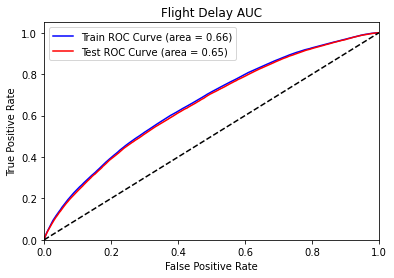

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

plt.plot(roc_curve(y_train, rf_preds_train['proba'])[0],roc_curve(y_train, rf_preds_train['proba'])[1], 
         color = 'blue', label='Train ROC Curve (area = %0.2f)' % roc_auc_score(y_train, rf_preds_train['proba']))

plt.plot(roc_curve(y_test, rf_preds_test['proba'])[0],roc_curve(y_test, rf_preds_test['proba'])[1], 
         color = 'red', label='Test ROC Curve (area = %0.2f)' % roc_auc_score(y_test, rf_preds_test['proba']))


plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Flight Delay AUC')
plt.legend()
plt.show()

## Predictions of Scheduled Flights Using Trained Model

In [51]:
#query for scheduled flights
qry = """select flight_master.flight_id, sched_date.day_of_week, airline_route.airline_id, 
route.origin, route.destination, route.distance, scheduled_time.departure as sched_departure, scheduled_time.arrival as sched_arrival from flight_master
join sched_date on flight_master.sched_date_id=sched_date.sched_date_id
join airline_route on flight_master.airline_route_id=airline_route.airline_route_id
join route on airline_route.route_id = route.route_id
Join scheduled_time on flight_master.flight_id=scheduled_time.flight_id
left join actual_time on flight_master.flight_id=actual_time.flight_id
left join cancellation on flight_master.flight_id=cancellation.flight_id
where actual_time.flight_id IS NULL AND cancellation.flight_id IS NULL;"""
df = pd.read_sql(qry, con=con)
df.head()

,flight_id,day_of_week,airline_id,origin,destination,distance,sched_departure,sched_arrival
0,1001608,4,B6,FLL,BDL,1173,2055,2352
1,1001212,4,OO,SLC,HLN,402,2015,2139
2,1002183,4,DL,ATL,AUS,813,2145,2309
3,1001360,4,AS,SEA,DEN,1024,2030,2358
4,1001600,4,OO,ICT,DEN,420,2054,2126


In [52]:
df.shape

(1099, 8)

In [53]:
#save df to append results
df_results = df.copy()

In [54]:
#create weekday binary variable (days 1-5 are weekdays)
df['weekday'] = np.where(df.day_of_week<=5,1,0)

In [55]:
#apply function is much faster than iterating through rows
df['sched_departure_min'] = df.sched_departure.apply(to_min)
df['sched_arrival_min'] = df.sched_arrival.apply(to_min)

In [56]:
df.head()

,flight_id,day_of_week,airline_id,origin,destination,distance,sched_departure,sched_arrival,weekday,sched_departure_min,sched_arrival_min
0,1001608,4,B6,FLL,BDL,1173,2055,2352,1,1255,1432
1,1001212,4,OO,SLC,HLN,402,2015,2139,1,1215,1299
2,1002183,4,DL,ATL,AUS,813,2145,2309,1,1305,1389
3,1001360,4,AS,SEA,DEN,1024,2030,2358,1,1230,1438
4,1001600,4,OO,ICT,DEN,420,2054,2126,1,1254,1286


In [57]:
#manually one hot encode so matches training model
df['_AA'] = np.where(df.airline_id=='_AA',1,0)
df['_AS'] = np.where(df.airline_id=='_AS',1,0)
df['_B6'] = np.where(df.airline_id=='_B6',1,0)
df['_DL'] = np.where(df.airline_id=='_DL',1,0)
df['_EV'] = np.where(df.airline_id=='_EV',1,0)
df['_F9'] = np.where(df.airline_id=='_F9',1,0)
df['_HA'] = np.where(df.airline_id=='_HA',1,0)
df['_MQ'] = np.where(df.airline_id=='_MQ',1,0)
df['_NK'] = np.where(df.airline_id=='_NK',1,0)
df['_OO'] = np.where(df.airline_id=='_OO',1,0)
df['_UA'] = np.where(df.airline_id=='_UA',1,0)
df['_US'] = np.where(df.airline_id=='_US',1,0)
df['_VX'] = np.where(df.airline_id=='_VX',1,0)
df['_WN'] = np.where(df.airline_id=='_WN',1,0)

In [58]:
#manually one hot encode airports (either arrival or departure) taking airports with >5000 origins from our dataset
#we could make columns for arrival/departure, then we would just need to create d_ATL, a_ATL, and not inlcude the or clause
df['ATL'] = np.where((df.origin=='ATL') | (df.destination=='ATL'), 1,0)
df['ORD'] = np.where((df.origin=='ORD') | (df.destination=='ORD'), 1,0)
df['DFW'] = np.where((df.origin=='DFW') | (df.destination=='DFW'), 1,0)
df['LAX'] = np.where((df.origin=='LAX') | (df.destination=='LAX'), 1,0)
df['DEN'] = np.where((df.origin=='DEN') | (df.destination=='DEN'), 1,0)
df['IAH'] = np.where((df.origin=='IAH') | (df.destination=='IAH'), 1,0)
df['PHX'] = np.where((df.origin=='PHX') | (df.destination=='PHX'), 1,0)
df['SFO'] = np.where((df.origin=='SFO') | (df.destination=='SFO'), 1,0)
df['LAS'] = np.where((df.origin=='LAS') | (df.destination=='LAS'), 1,0)
df['MCO'] = np.where((df.origin=='MCO') | (df.destination=='MCO'), 1,0)
df['LGA'] = np.where((df.origin=='LGA') | (df.destination=='LGA'), 1,0)
df['DTW'] = np.where((df.origin=='DTW') | (df.destination=='DTW'), 1,0)
df['CLT'] = np.where((df.origin=='CLT') | (df.destination=='CLT'), 1,0)
df['BOS'] = np.where((df.origin=='BOS') | (df.destination=='BOS'), 1,0)
df['MSP'] = np.where((df.origin=='MSP') | (df.destination=='MSP'), 1,0)
df['EWR'] = np.where((df.origin=='EWR') | (df.destination=='EWR'), 1,0)
df['SLC'] = np.where((df.origin=='SLC') | (df.destination=='SLC'), 1,0)
df['JFK'] = np.where((df.origin=='JFK') | (df.destination=='JFK'), 1,0)
df['SEA'] = np.where((df.origin=='SEA') | (df.destination=='SEA'), 1,0)
df['FLL'] = np.where((df.origin=='FLL') | (df.destination=='FLL'), 1,0)
df['BWI'] = np.where((df.origin=='BWI') | (df.destination=='BWI'), 1,0)
df['DCA'] = np.where((df.origin=='DCA') | (df.destination=='DCA'), 1,0)
df['MDW'] = np.where((df.origin=='MDW') | (df.destination=='MDW'), 1,0)
df['MIA'] = np.where((df.origin=='MIA') | (df.destination=='MIA'), 1,0)
df['SAN'] = np.where((df.origin=='SAN') | (df.destination=='SAN'), 1,0)
df['TPA'] = np.where((df.origin=='TPA') | (df.destination=='TPA'), 1,0)
df['PHL'] = np.where((df.origin=='PHL') | (df.destination=='PHL'), 1,0)
df['DAL'] = np.where((df.origin=='DAL') | (df.destination=='DAL'), 1,0)
df['HOU'] = np.where((df.origin=='HOU') | (df.destination=='HOU'), 1,0)
df['BNA'] = np.where((df.origin=='BNA') | (df.destination=='BNA'), 1,0)
df['STL'] = np.where((df.origin=='STL') | (df.destination=='STL'), 1,0)
df['HNL'] = np.where((df.origin=='HNL') | (df.destination=='HNL'), 1,0)
df['OAK'] = np.where((df.origin=='OAK') | (df.destination=='OAK'), 1,0)
df['PDX'] = np.where((df.origin=='PDX') | (df.destination=='PDX'), 1,0)
df['MSY'] = np.where((df.origin=='MSY') | (df.destination=='MSY'), 1,0)
df['IAD'] = np.where((df.origin=='IAD') | (df.destination=='IAD'), 1,0)
df['AUS'] = np.where((df.origin=='AUS') | (df.destination=='AUS'), 1,0)
df['SJC'] = np.where((df.origin=='SJC') | (df.destination=='SJC'), 1,0)
df['RSW'] = np.where((df.origin=='RSW') | (df.destination=='RSW'), 1,0)
df['SMF'] = np.where((df.origin=='SMF') | (df.destination=='SMF'), 1,0)
df['SNA'] = np.where((df.origin=='SNA') | (df.destination=='SNA'), 1,0)
df['MCI'] = np.where((df.origin=='MCI') | (df.destination=='MCI'), 1,0)
df['CLE'] = np.where((df.origin=='CLE') | (df.destination=='CLE'), 1,0)
df['RDU'] = np.where((df.origin=='RDU') | (df.destination=='RDU'), 1,0)
df['MKE'] = np.where((df.origin=='MKE') | (df.destination=='MKE'), 1,0)
df['SAT'] = np.where((df.origin=='SAT') | (df.destination=='SAT'), 1,0)
df['PBI'] = np.where((df.origin=='PBI') | (df.destination=='PBI'), 1,0)

In [59]:
df.head()

,flight_id,day_of_week,airline_id,origin,destination,distance,sched_departure,sched_arrival,weekday,sched_departure_min,sched_arrival_min,_AA,_AS,_B6,_DL,_EV,_F9,_HA,_MQ,_NK,_OO,_UA,_US,_VX,_WN,ATL,ORD,DFW,LAX,DEN,IAH,PHX,SFO,LAS,MCO,LGA,DTW,CLT,BOS,MSP,EWR,SLC,JFK,SEA,FLL,BWI,DCA,MDW,MIA,SAN,TPA,PHL,DAL,HOU,BNA,STL,HNL,OAK,PDX,MSY,IAD,AUS,SJC,RSW,SMF,SNA,MCI,CLE,RDU,MKE,SAT,PBI
0,1001608,4,B6,FLL,BDL,1173,2055,2352,1,1255,1432,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1001212,4,OO,SLC,HLN,402,2015,2139,1,1215,1299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1002183,4,DL,ATL,AUS,813,2145,2309,1,1305,1389,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1001360,4,AS,SEA,DEN,1024,2030,2358,1,1230,1438,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1001600,4,OO,ICT,DEN,420,2054,2126,1,1254,1286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
#drop identity, non-cleaned, or results columns
x_vars = df.drop(columns=['flight_id','airline_id', 'day_of_week', 'origin', 'destination',
                          'sched_departure', 'sched_arrival'])

In [61]:
x_vars.head()

,distance,weekday,sched_departure_min,sched_arrival_min,_AA,_AS,_B6,_DL,_EV,_F9,_HA,_MQ,_NK,_OO,_UA,_US,_VX,_WN,ATL,ORD,DFW,LAX,DEN,IAH,PHX,SFO,LAS,MCO,LGA,DTW,CLT,BOS,MSP,EWR,SLC,JFK,SEA,FLL,BWI,DCA,MDW,MIA,SAN,TPA,PHL,DAL,HOU,BNA,STL,HNL,OAK,PDX,MSY,IAD,AUS,SJC,RSW,SMF,SNA,MCI,CLE,RDU,MKE,SAT,PBI
0,1173,1,1255,1432,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,402,1,1215,1299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,813,1,1305,1389,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1024,1,1230,1438,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,420,1,1254,1286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
#predict using pretrained model
rf_sched_probs = rf_clf_model.predict_proba(x_vars)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [63]:
df_results['delay_likelihood'] = rf_sched_probs[:,1]

In [64]:
#results with probabilities
df_results

,flight_id,day_of_week,airline_id,origin,destination,distance,sched_departure,sched_arrival,delay_likelihood
0,1001608,4,B6,FLL,BDL,1173,2055,2352,0.178587
1,1001212,4,OO,SLC,HLN,402,2015,2139,0.203541
2,1002183,4,DL,ATL,AUS,813,2145,2309,0.246647
3,1001360,4,AS,SEA,DEN,1024,2030,2358,0.172065
4,1001600,4,OO,ICT,DEN,420,2054,2126,0.270982
5,1001710,4,EV,ATL,MGM,147,2100,2055,0.251286
6,1001136,4,AA,ORD,SFO,1846,2013,2300,0.291502
7,1001432,4,UA,LIH,LAX,2615,2035,500,0.241592
8,1001344,4,OO,SBA,SFO,262,2027,2140,0.268117
9,1001849,4,DL,ATL,CAK,528,2115,2259,0.251121
